# Importando pacotes

In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import netCDF4 as nc
import pandas as pd
import rasterio
from rasterio.plot import show
from pathlib import Path

# Lendo os arquivos

In [2]:
# Abrindo arquivos
path = Path(r'C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\dados_entrada\congonhas')
files = [i for i in path.rglob('*.tif')]

In [3]:
# Carregandi DataArrays
xdas = [rxr.open_rasterio(file) for file in files]
xdas

[<xarray.DataArray (band: 3, y: 24064, x: 24064)> Size: 2GB
 [1737228288 values with dtype=uint8]
 Coordinates:
   * band         (band) int64 24B 1 2 3
   * x            (x) float64 193kB -46.05 -46.05 -46.05 ... -41.92 -41.92 -41.92
   * y            (y) float64 193kB -18.15 -18.15 -18.15 ... -22.02 -22.02 -22.02
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     scale_factor:   1.0
     add_offset:     0.0,
 <xarray.DataArray (band: 3, y: 24064, x: 24064)> Size: 2GB
 [1737228288 values with dtype=uint8]
 Coordinates:
   * band         (band) int64 24B 1 2 3
   * x            (x) float64 193kB -46.05 -46.05 -46.05 ... -41.92 -41.92 -41.92
   * y            (y) float64 193kB -18.15 -18.15 -18.15 ... -22.02 -22.02 -22.02
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     scale_factor:   1.0
     add_offset:     0.0,
 <xarray.DataArray (band: 3, y: 24064, x: 24064)> Size: 2GB
 [1737228288 values with dtype=uint8]
 Coordinates:
   * band       

# Indexando pelo tempo

In [4]:
# Criando índices de tempo a partir dos nomes dos arquivos
def time_index_from_filenames(filenames):
    # congonhas_YYYY-MM-DD_HH-MM-SS
    times = []
    for file in filenames:
        only_file = os.path.basename(file)
        time = pd.to_datetime(only_file.split('_')[1] + ' ' + only_file.split('_')[2].replace('-', ':')[:8], format='%Y-%m-%d %H:%M:%S')
        times.append(time)
    return pd.DatetimeIndex(times)

In [5]:
# Carregandi índices de tempo
time_indexes = time_index_from_filenames([file.stem for file in files])
time_indexes = xr.Variable('time', time_indexes)
time_indexes

<xarray.Variable (time: 3)> Size: 24B
array(['2024-10-05T10:00:00.000000000', '2024-10-05T11:00:00.000000000',
       '2024-10-05T12:00:00.000000000'], dtype='datetime64[ns]')

# Concatenando os DataArrays em um Dataset

In [6]:
# Concatenando pela dimensão de tempo
ds = xr.concat(xdas, dim=time_indexes)
ds
del xdas

# Analisando os pixels e classificando

In [8]:
# Cores de limites
limits = {'0':'#000000',
          '1':"#777777",
          '2':'#FF2323',
          '3':'#FFFF37',
          '4':'#2BC82B'}

# Transformando os valores haxadecimais em rgb
r_values = [int(limit[1:3], 16) for limit in limits.values()]
print(r_values)
g_values = [int(limit[3:5], 16) for limit in limits.values()]
print(g_values)
b_values = [int(limit[5:8], 16) for limit in limits.values()]
print(b_values)

rgb_values = [list(i) for i in zip(r_values,g_values,b_values)]
rgb_values = dict(zip(limits.keys(),rgb_values))
print(rgb_values)
print(ds.shape)
del r_values, g_values, b_values

[0, 119, 255, 255, 43]
[0, 119, 35, 255, 200]
[0, 119, 35, 55, 43]
{'0': [0, 0, 0], '1': [119, 119, 119], '2': [255, 35, 35], '3': [255, 255, 55], '4': [43, 200, 43]}
(3, 3, 24064, 24064)


In [24]:
x=0
y=0
pixel_values = [ds.isel(x=x,y=y,time=0, band=0).values.item(),
                           ds.isel(x=x,y=y,time=0, band=1).values.item(),
                           ds.isel(x=x,y=y,time=0, band=2).values.item()]
print('Valor RGB do pixel: '+ str(pixel_values))

for classification, rgb_value in rgb_values.items():
                if pixel_value == rgb_value:
                    class_df.iloc[x,y]= classification
                    print("Classificação do pixel: "+ class_df.iloc[x,y])
                    

Valor RGB do pixel: [0, 0, 0]
Classificação do pixel: 0


In [52]:
rgb_values
testAll=[]
for classification, rgb_value in rgb_values.items():
    print(classification)
    print(rgb_value)
    print(rgb_value[0])
    testband0 = (ds[:,0,:,:]==rgb_value[0]) 
    testband1 = (ds[:,1,:,:]==rgb_value[1]) 
    testband2 = (ds[:,2,:,:]==rgb_value[2])
    testAll.append(testband0 & testband1 & testband2)

del testband0, testband1, testband2
testAll = np.concat(testAll)

0
[0, 0, 0]
0


MemoryError: Unable to allocate 552. MiB for an array with shape (24064, 24064) and data type bool

In [51]:
#import matplotlib.pyplot as plt 
#plt.pcolor(testAll)
testAll.shape

(24064, 24064)

In [19]:
# Comparando a cor dos pixels do tempo 0 com o RGB específico de cada classe e classificando
for x in range(24064):
        for y in range(24064):
            pixel_value = [ds.isel(x=x,y=y,time=0, band=0).values.item(),
                           ds.isel(x=x,y=y,time=0, band=1).values.item(),
                           ds.isel(x=x,y=y,time=0, band=2).values.item()]
            
            for classification, rgb_value in rgb_values.items():
                if pixel_value == rgb_value:
                    class_df.iloc[x,y]= classification
                    break


KeyboardInterrupt: 

# Importando a base de dados

In [2]:
# pasta de dados
pastaDados = r"C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\dados_entrada\dados_T2"
listaDados = os.listdir(pastaDados)

#Listando arquivos
print(listaDados)
print('\n')

# Selecionando arquivos do GLDAS
prefixed = [filename for filename in listaDados if filename.startswith('GLDAS')]
print(prefixed)

['GLDAS_VIC10_3H.A20020101.0000.020.nc4', 'GLDAS_VIC10_3H.A20020101.0300.020.nc4', 'GLDAS_VIC10_3H.A20020101.0600.020.nc4', 'GLDAS_VIC10_3H.A20020101.0900.020.nc4', 'GLDAS_VIC10_3H.A20020101.1200.020.nc4', 'GLDAS_VIC10_3H.A20020101.1500.020.nc4', 'GLDAS_VIC10_3H.A20020101.1800.020.nc4', 'GLDAS_VIC10_3H.A20020101.2100.020.nc4', 'GLDAS_VIC10_3H.A20020102.0000.020.nc4', 'GLDAS_VIC10_3H.A20020102.0300.020.nc4', 'GLDAS_VIC10_3H.A20020102.0600.020.nc4', 'GLDAS_VIC10_3H.A20020102.0900.020.nc4', 'GLDAS_VIC10_3H.A20020102.1200.020.nc4', 'GLDAS_VIC10_3H.A20020102.1500.020.nc4', 'GLDAS_VIC10_3H.A20020102.1800.020.nc4', 'GLDAS_VIC10_3H.A20020102.2100.020.nc4', 'README_GLDAS2.pdf', 'subset_GLDAS_VIC10_3H_2.0_20241122_003313_.txt']


['GLDAS_VIC10_3H.A20020101.0000.020.nc4', 'GLDAS_VIC10_3H.A20020101.0300.020.nc4', 'GLDAS_VIC10_3H.A20020101.0600.020.nc4', 'GLDAS_VIC10_3H.A20020101.0900.020.nc4', 'GLDAS_VIC10_3H.A20020101.1200.020.nc4', 'GLDAS_VIC10_3H.A20020101.1500.020.nc4', 'GLDAS_VIC10_3H.A200201

In [83]:
# Indo até a pasta de dados
os.chdir(pastaDados)

# Abrindo os arquivos do GLDAS e concatenando eles pelas coordenadas
dataset = xr.open_mfdataset(prefixed)
print(dataset.data_vars)

Data variables:
    time_bnds            (time, bnds) datetime64[ns] 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    Swnet_tavg           (time, lat, lon) float32 3MB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Lwnet_tavg           (time, lat, lon) float32 3MB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Qle_tavg             (time, lat, lon) float32 3MB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Qh_tavg              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Qg_tavg              (time, lat, lon) float32 3MB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Snowf_tavg           (time, lat, lon) float32 3MB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Rainf_tavg           (time, lat, lon) float32 3MB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Evap_tavg            (time, lat, lon) float32 3MB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    Qs_acc              

# Soil Moisture 30cm

In [84]:
# Acessando os dados de root moisture
soilMoist30 = dataset['SoilMoi0_30cm_inst'][:]
print(soilMoist30.head())

<xarray.DataArray 'SoilMoi0_30cm_inst' (time: 5, lat: 5, lon: 5)> Size: 500B
dask.array<getitem, shape=(5, 5, 5), dtype=float32, chunksize=(1, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 40B 2002-01-01 ... 2002-01-01T12:00:00
  * lon      (lon) float32 20B -179.5 -178.5 -177.5 -176.5 -175.5
  * lat      (lat) float32 20B -59.5 -58.5 -57.5 -56.5 -55.5
Attributes:
    standard_name:  soil_moisture_content
    long_name:      Soil moisture
    units:          kg m-2
    cell_methods:   time: point
    vmin:           7.5000005
    vmax:           163.57956


C:\Users\bruno\AppData\Local\Temp\ipykernel_12736\65280257.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(a ,ax=ax, extend = 'max', shrink=0.685)


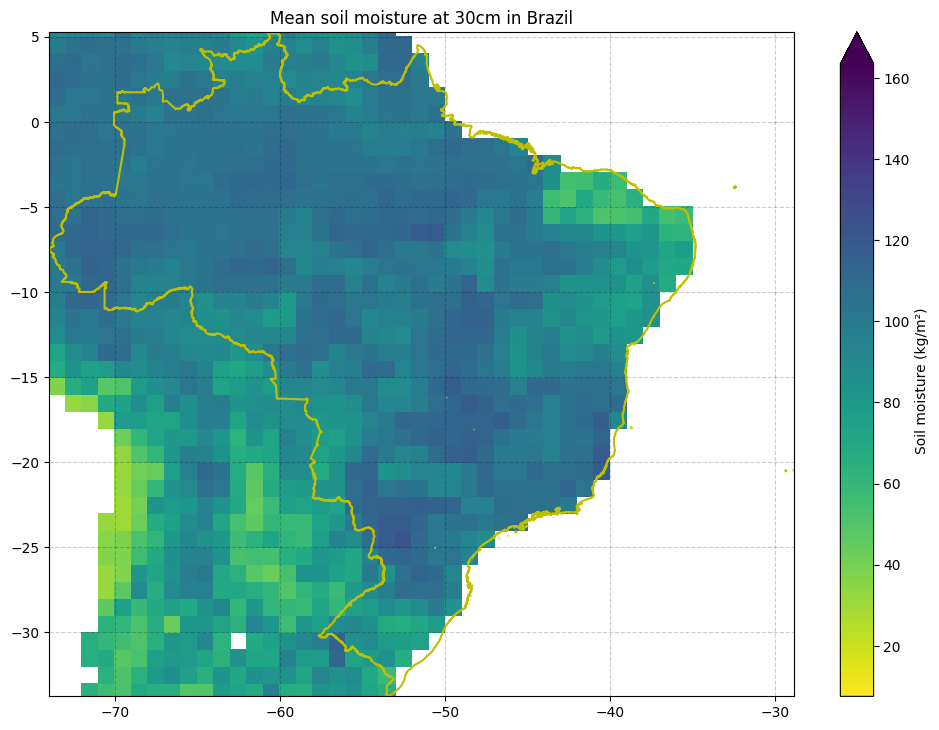

In [85]:
# Plotando em 2D
br = gpd.read_file(r"C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\dados_entrada\BR_Pais_2022\BR_Pais_2022.shp")

fig,ax = plt.subplots(figsize=(10,10))

# média do dia em todos os locais do brasil
a = ax.pcolor(dataset['lon'][:], dataset['lat'], np.mean(soilMoist30, axis=0), cmap='viridis_r')
br.boundary.plot(ax=ax, color="y")
ax.set_xlim([br.bounds.minx[0], br.bounds.maxx[0]])
ax.set_ylim([br.bounds.miny[0], br.bounds.maxy[0]])
ax.set_title('Mean soil moisture at 30cm in Brazil')
ax.grid(which='major', linestyle="--", color='black', alpha=0.2)

cbar = fig.colorbar(a ,ax=ax, extend = 'max', shrink=0.685)
cbar.set_label('Soil moisture (kg/m²)')
plt.tight_layout()

In [86]:
# Criar um DataArray a partir dos dados de soil moisture 30 cm
da0 = xr.DataArray(
      data = soilMoist30,
      dims = ["time","y","x"],
      coords = dict(
            x = (["x"], dataset['lon'].to_numpy()),
            y = (["y"], dataset['lat'].to_numpy()),
      )
)

# Designar um SRC para o DataArray
da = da0.rio.write_crs("epsg:4326", inplace=True)

# Cortar os dados para a área do Brasil
geodf = br.copy()
clipped = da.rio.clip(geodf.geometry.apply(mapping), geodf.crs,drop=False)

# Salvando o DataArray como um netCDF
clipped.to_netcdf('ClipBR.nc')

In [88]:
# Plotando em 1D o recorte
print(dataset['lat'].ndim)
lat = np.argmin(abs(dataset['lat'][:] - (-27)))
lon = np.argmin(abs(dataset['lon'][:] - (-50)))
print(lat.ndim)
#arr = clipped.isel(y=lat, x=lon)
#arr.plot()

1


ValueError: dimensions ('lat',) must have the same length as the number of data dimensions, ndim=0

# Sensible heat net flux

In [13]:
# Acessando os dados de root moisture
sensHeatFlux = dataset['Qh_tavg'][:]
print(sensHeatFlux.head())

<xarray.DataArray 'Qh_tavg' (time: 5, lat: 5, lon: 5)> Size: 500B
dask.array<getitem, shape=(5, 5, 5), dtype=float32, chunksize=(1, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 40B 2002-01-01 ... 2002-01-01T12:00:00
  * lon      (lon) float32 20B -179.5 -178.5 -177.5 -176.5 -175.5
  * lat      (lat) float32 20B -59.5 -58.5 -57.5 -56.5 -55.5
Attributes:
    standard_name:  surface_upward_sensible_heat_flux
    long_name:      Sensible heat net flux
    units:          W m-2
    cell_methods:   time: mean
    vmin:           -139.58366
    vmax:           501.2171


C:\Users\bruno\AppData\Local\Temp\ipykernel_12736\815686561.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(a ,ax=ax, extend = 'max', shrink=0.685)


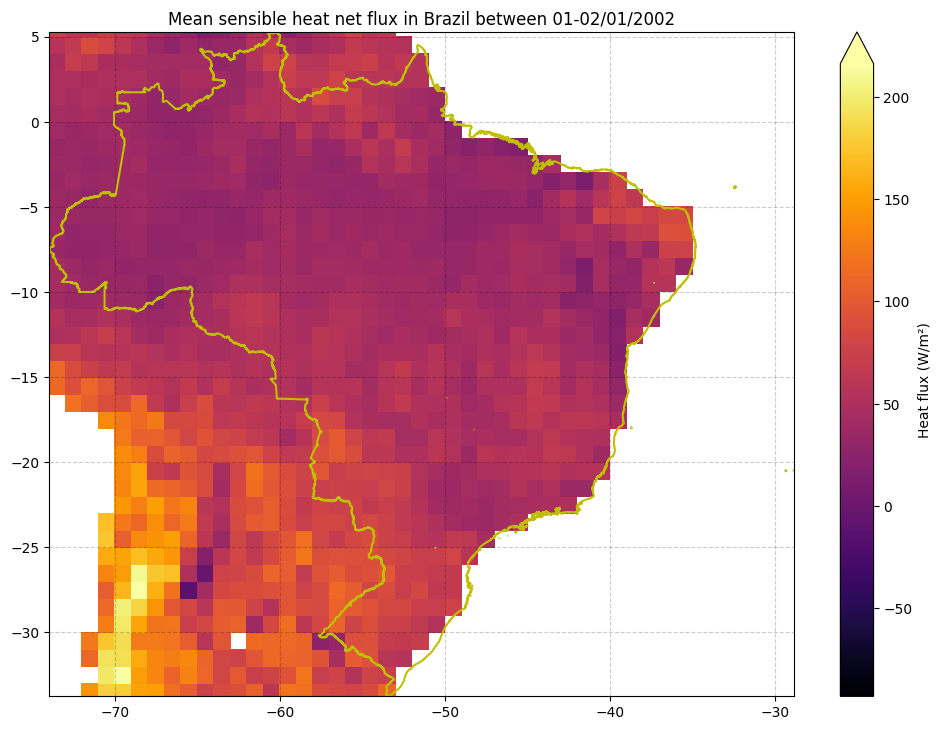

In [74]:
# Plotando em 2D
br = gpd.read_file(r"C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\dados_entrada\BR_Pais_2022\BR_Pais_2022.shp")

fig,ax = plt.subplots(figsize=(10,10))

# média do dia em todos os locais do brasil
a = ax.pcolor(dataset['lon'][:], dataset['lat'], np.mean(sensHeatFlux, axis=0), cmap='inferno')
br.boundary.plot(ax=ax, color="y")
ax.set_xlim([br.bounds.minx[0], br.bounds.maxx[0]])
ax.set_ylim([br.bounds.miny[0], br.bounds.maxy[0]])
ax.set_title('Mean sensible heat net flux in Brazil between 01-02/01/2002')
ax.grid(which='major', linestyle="--", color='black', alpha=0.2)

cbar = fig.colorbar(a ,ax=ax, extend = 'max', shrink=0.685)
cbar.set_label('Heat flux (W/m²)')
plt.tight_layout()

# Albedo

In [60]:
# Acessando os dados de root moisture
albedo = dataset['Albedo_inst'][:]
#print(albedo.head())

print(np.min(np.mean(albedo, axis=0)).ndim)

0


C:\Users\bruno\AppData\Local\Temp\ipykernel_12736\3920540241.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(a,ax=ax, extend = 'max', shrink=0.685)


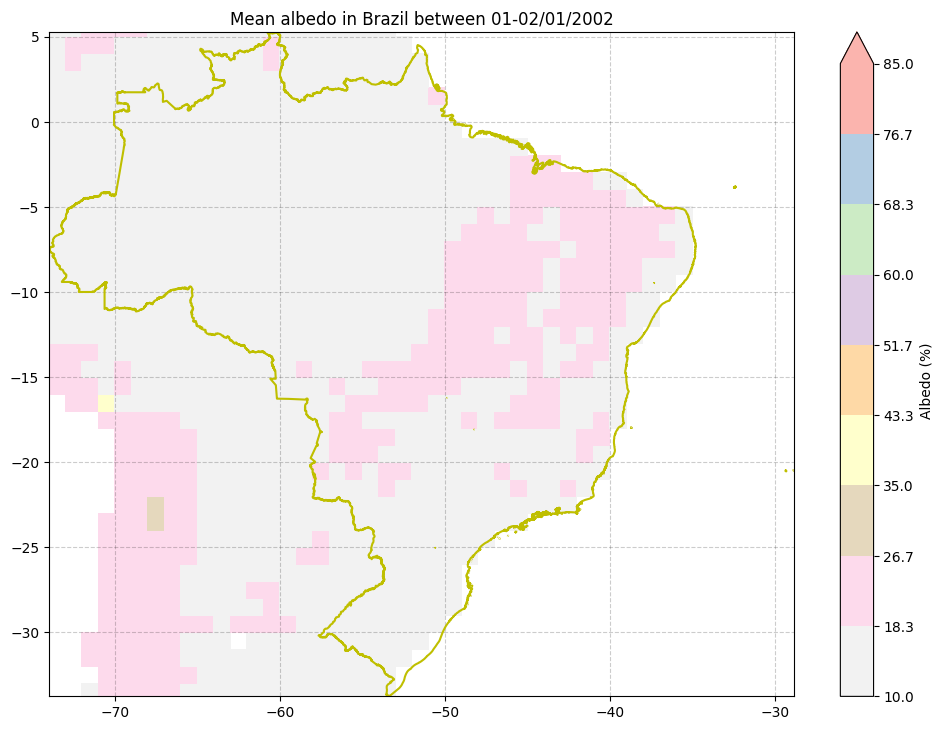

In [71]:
# Plotando em 2D
br = gpd.read_file(r"C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\dados_entrada\BR_Pais_2022\BR_Pais_2022.shp")

fig,ax = plt.subplots(figsize=(10,10))

# Média do dia em todos os locais do brasil
a = ax.pcolor(dataset['lon'][:], dataset['lat'], np.mean(albedo, axis=0), cmap='Pastel1_r')
br.boundary.plot(ax=ax, color="y")
ax.set_xlim([br.bounds.minx[0], br.bounds.maxx[0]])
ax.set_ylim([br.bounds.miny[0], br.bounds.maxy[0]])
ax.set_title('Mean albedo in Brazil between 01-02/01/2002')
ax.grid(which='major', linestyle="--", color='black', alpha=0.2)

# Configurando colorbar
cbar = fig.colorbar(a,ax=ax, extend = 'max', shrink=0.685)
cbar.set_label('Albedo (%)')

# Definindo limites do colorbar para que os ticks batam com as divisões de cor
boundaries = np.linspace(
        np.array(np.min(np.mean(albedo, axis=0))),        # usa np.array porque np.min retorna um scalar e precisa ser ndim=1 para funcionar 
        np.array(np.max(np.mean(albedo, axis=0))),
        10)
cbar.set_ticks(boundaries) 
cbar.set_ticklabels([f'{tick:.1f}' for tick in boundaries])

plt.tight_layout()